In [1]:
%matplotlib inline

# Import Dependencies

In [2]:
# System & OS
import warnings
warnings.filterwarnings('ignore')
# Data Storage
from google.colab import drive
# Data Analysis
import math
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import chisquare, pearsonr
# Data Visualization
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
# Miscellaneous
from decimal import Decimal

# Mount Storage

In [3]:
# Mount Google Drive to Colab Instance
drive.mount('/content/drive')
# Change directory to where the data are stored (old: %cd '/content/drive/MyDrive/Research/Ongoing/Protostellar Luminosity/Data')
%cd '/content/drive/MyDrive/Colab Notebooks/Data'

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1EKq5q8_K4j5NQpcWKFDhxA77zKtxtbug/Data


# Data Visualization

In [164]:
df = pd.read_csv('master_file.csv', skiprows=1, names=['Model number',
                                                       'Class', 
                                                       'Mass ratio', 
                                                       'Timestep', 
                                                       'Inclination', 
                                                       'Wavelength (cm)', 
                                                       'Flux (erg cm^-2 s^-1)', 
                                                       'L_int (Lsun)'])
df

,Model number,Class,Mass ratio,Timestep,Inclination,Wavelength (cm),Flux (erg cm^-2 s^-1),L_int (Lsun)
0,1,0,0.034096,2,5,3.600030,1.171193e-18,0.001486
1,1,0,0.034096,2,5,2.400020,4.342741e-18,0.001486
2,1,0,0.034096,2,5,1.600013,1.734933e-17,0.001486
3,1,0,0.034096,2,5,1.300011,3.665945e-17,0.001486
4,1,0,0.034096,2,5,1.100009,6.839343e-17,0.001486
...,...,...,...,...,...,...,...,...
8993595,33,1,0.885142,379,85,0.000025,2.878049e-13,5.9644
8993596,33,1,0.885142,379,85,0.000020,1.755736e-14,5.9644
8993597,33,1,0.885142,379,85,0.000015,-1.782472e-16,5.9644
8993598,33,1,0.885142,379,85,0.000010,-1.308467e-17,5.9644


In [165]:
# Drop irrelevant columns
df.drop(columns=['Timestep', 'Inclination'], inplace=True)

# Typecast objects to float64 or str
df['Mass ratio'] = df['Mass ratio'].apply(lambda x: float(x))
df['L_int (Lsun)'] = df['L_int (Lsun)'].apply(lambda x: float(x))
df['Class'] = df['Class'].apply(lambda x: str(x))

# Subdivide class 1 into 1a and 1b
df.loc[(df['Mass ratio'] >= 0.5) & (df['Mass ratio'] < 0.75), 'Class'] = '1a'
df.loc[df['Mass ratio'] >= 0.75, 'Class'] = '1b'

# Add columns with logged data
df['log(Flux)'] = np.log10(df['Flux (erg cm^-2 s^-1)'].values)
df['log(L_int)'] = np.log10(df['L_int (Lsun)'].values)

# Drop rows with L_int < 0.1
df = df[df['L_int (Lsun)'] >= 0.1]

# Drop missing values and infinities
print(f'Percentage of missing values (before handling):\n\n{round(df.isnull().sum().sort_values(ascending=False) / len(df.index) * 100, 2)}\n')
df = df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
print(f'Percentage of missing values (after handling):\n\n{round(df.isnull().sum().sort_values(ascending=False) / len(df.index) * 100, 2)}\n')

# Print status
print(f'Number of rows dropped: {8993600 - len(df)}\n')

# Display dataframe
df

Percentage of missing values (before handling):

log(Flux)                1.49
Model number             0.00
Class                    0.00
Mass ratio               0.00
Wavelength (cm)          0.00
Flux (erg cm^-2 s^-1)    0.00
L_int (Lsun)             0.00
log(L_int)               0.00
dtype: float64

Percentage of missing values (after handling):

Model number             0.0
Class                    0.0
Mass ratio               0.0
Wavelength (cm)          0.0
Flux (erg cm^-2 s^-1)    0.0
L_int (Lsun)             0.0
log(Flux)                0.0
log(L_int)               0.0
dtype: float64

Number of rows dropped: 1237401



,Model number,Class,Mass ratio,Wavelength (cm),Flux (erg cm^-2 s^-1),L_int (Lsun),log(Flux),log(L_int)
15300,1,0,0.360994,3.600030,1.707756e-19,2.0869,-18.767574,0.319502
15301,1,0,0.360994,2.400020,1.187698e-18,2.0869,-17.925294,0.319502
15302,1,0,0.360994,1.600013,8.241456e-18,2.0869,-17.083996,0.319502
15303,1,0,0.360994,1.300011,2.219241e-17,2.0869,-16.653795,0.319502
15304,1,0,0.360994,1.100009,4.919182e-17,2.0869,-16.308107,0.319502
...,...,...,...,...,...,...,...,...
8993592,33,1b,0.885142,0.000040,1.193031e-11,5.9644,-10.923348,0.775567
8993593,33,1b,0.885142,0.000035,5.392117e-12,5.9644,-11.268241,0.775567
8993594,33,1b,0.885142,0.000030,1.622111e-12,5.9644,-11.789919,0.775567
8993595,33,1b,0.885142,0.000025,2.878049e-13,5.9644,-12.540902,0.775567


In [56]:
with open('lin_coef.csv', 'w') as coef, open('corr_coef.csv', 'w') as corr:
  coef.write('Model number,Class,Wavelength (cm),Slope,Unc_slope,Intercept,Unc_intercept\n')
  corr.write('Model number,Class,Wavelength (cm),Reduced chi-squared (linear space),Reduced chi-squared (log10 space),Correlation coefficient (linear space),Correlation coefficient (log10 space)\n')
  # Initialize progress bar
  with tqdm(total=df['Wavelength (cm)'].nunique() * 4 + 4, leave=True) as pbar:
    # Master plot: Class 2 (0 & 1)
    plt.scatter(df['L_int (Lsun)'], df['Flux (erg cm^-2 s^-1)'], s=10)
    plt.title('Flux vs Internal Luminosity: Class 0 & 1')
    plt.xlabel('Internal Luminosity (L$_{sun}$)')
    plt.ylabel('Flux (erg cm$^{-2}$ s$^{-1}$)')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(1e-1, 1e5)
    plt.ylim(1e-12, 1e-5)

    # Fit linear regression
    flux = sm.add_constant(df['log(Flux)'])
    model = sm.OLS(df['log(L_int)'], flux)
    results = model.fit()
    m, unc_m, b, unc_b = results.params[1], results.bse[1], results.params[0], results.bse[0]
    coef.write(f'All,2,All,{m},{unc_m},{b},{unc_b}\n')

    # Visualize linear regression
    L = np.linspace(1e-1, 1e5)
    F = L**m * 10**b
    plt.plot(L, F, color='k')
    plt.legend([f'$y = 10^{{{b:.3f}}} \cdot x^{{{m:.3f}}}$', f'All wavelengths'])

    # Compute reduced chi-squared
    lin_rcs, _ = pearsonr(df['Flux (erg cm^-2 s^-1)'], df['L_int (Lsun)']**m * 10**b)
    log_rcs, _ = pearsonr(df['log(Flux)'], m * df['log(L_int)'] + b)

    # Compute correlation coefficient
    lin_corr, _ = pearsonr(df['L_int (Lsun)'], df['Flux (erg cm^-2 s^-1)'])
    log_corr, _ = pearsonr(df['log(L_int)'], df['log(Flux)'])
    corr.write(f'All,2,All,{lin_rcs},{log_rcs},{lin_corr},{log_corr}\n')

    # Save figure & update progress bar
    plt.savefig(f'Figures/flux_vs_lint_2_master.jpg')
    plt.clf()
    pbar.update(1)

    # Master plot: Class 0
    df_0 = df[df['Class'] == '0']
    plt.scatter(df_0['L_int (Lsun)'], df_0['Flux (erg cm^-2 s^-1)'], s=10)
    plt.title('Flux vs Internal Luminosity: Class 0')
    plt.xlabel('Internal Luminosity (L$_{sun}$)')
    plt.ylabel('Flux (erg cm$^{-2}$ s$^{-1}$)')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(1e-1, 1e5)
    plt.ylim(1e-12, 1e-5)

    # Fit linear regression
    flux = sm.add_constant(df_0['log(Flux)'])
    model = sm.OLS(df_0['log(L_int)'], flux)
    results = model.fit()
    m, unc_m, b, unc_b = results.params[1], results.bse[1], results.params[0], results.bse[0]
    coef.write(f'All,0,All,{m},{unc_m},{b},{unc_b}\n')

    # Visualize linear regression
    L = np.linspace(1e-1, 1e5)
    F = L**m * 10**b
    plt.plot(L, F, color='k')
    plt.legend([f'$y = 10^{{{b:.3f}}} \cdot x^{{{m:.3f}}}$', f'All wavelengths'])

    # Compute reduced chi-squared
    lin_rcs, _ = pearsonr(df_0['Flux (erg cm^-2 s^-1)'], df_0['L_int (Lsun)']**m * 10**b)
    log_rcs, _ = pearsonr(df_0['log(Flux)'], m * df_0['log(L_int)'] + b)

    # Compute correlation coefficient
    lin_corr, _ = pearsonr(df_0['L_int (Lsun)'], df_0['Flux (erg cm^-2 s^-1)'])
    log_corr, _ = pearsonr(df_0['log(L_int)'], df_0['log(Flux)'])
    corr.write(f'All,0,All,{lin_rcs},{log_rcs},{lin_corr},{log_corr}\n')

    # Save figure & update progress bar
    plt.savefig(f'Figures/flux_vs_lint_0_master.jpg')
    plt.clf()
    pbar.update(1)

    # Master plot: Class 1a
    df_1a = df[df['Class'] == '1a']
    plt.scatter(df_1a['L_int (Lsun)'], df_1a['Flux (erg cm^-2 s^-1)'], s=10)
    plt.title('Flux vs Internal Luminosity: Class 1a')
    plt.xlabel('Internal Luminosity (L$_{sun}$)')
    plt.ylabel('Flux (erg cm$^{-2}$ s$^{-1}$)')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(1e-1, 1e5)
    plt.ylim(1e-12, 1e-5)

    # Fit linear regression
    flux = sm.add_constant(df_1a['log(Flux)'])
    model = sm.OLS(df_1a['log(L_int)'], flux)
    results = model.fit()
    m, unc_m, b, unc_b = results.params[1], results.bse[1], results.params[0], results.bse[0]
    coef.write(f'All,1a,All,{m},{unc_m},{b},{unc_b}\n')

    # Visualize linear regression
    L = np.linspace(1e-1, 1e5)
    F = L**m * 10**b
    plt.plot(L, F, color='k')
    plt.legend([f'$y = 10^{{{b:.3f}}} \cdot x^{{{m:.3f}}}$', f'All wavelengths'])

    # Compute reduced chi-squared
    lin_rcs, _ = pearsonr(df_1a['Flux (erg cm^-2 s^-1)'], df_1a['L_int (Lsun)']**m * 10**b)
    log_rcs, _ = pearsonr(df_1a['log(Flux)'], m * df_1a['log(L_int)'] + b)

    # Compute correlation coefficient
    lin_corr, _ = pearsonr(df_1a['L_int (Lsun)'], df_1a['Flux (erg cm^-2 s^-1)'])
    log_corr, _ = pearsonr(df_1a['log(L_int)'], df_1a['log(Flux)'])
    corr.write(f'All,1a,All,{lin_rcs},{log_rcs},{lin_corr},{log_corr}\n')

    # Save figure & update progress bar
    plt.savefig(f'Figures/flux_vs_lint_1a_master.jpg')
    plt.clf()
    pbar.update(1)

    # Master plot: Class 1b
    df_1b = df[df['Class'] == '1b']
    plt.scatter(df_1b['L_int (Lsun)'], df_1b['Flux (erg cm^-2 s^-1)'], s=10)
    plt.title('Flux vs Internal Luminosity: Class 1b')
    plt.xlabel('Internal Luminosity (L$_{sun}$)')
    plt.ylabel('Flux (erg cm$^{-2}$ s$^{-1}$)')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(1e-1, 1e5)
    plt.ylim(1e-12, 1e-5)

    # Fit linear regression
    flux = sm.add_constant(df_1b['log(Flux)'])
    model = sm.OLS(df_1b['log(L_int)'], flux)
    results = model.fit()
    m, unc_m, b, unc_b = results.params[1], results.bse[1], results.params[0], results.bse[0]
    coef.write(f'All,1b,All,{m},{unc_m},{b},{unc_b}\n')

    # Visualize linear regression
    L = np.linspace(1e-1, 1e5)
    F = L**m * 10**b
    plt.plot(L, F, color='k')
    plt.legend([f'$y = 10^{{{b:.3f}}} \cdot x^{{{m:.3f}}}$', f'All wavelengths'])

    # Compute reduced chi-squared
    lin_rcs, _ = pearsonr(df_1b['Flux (erg cm^-2 s^-1)'], df_1b['L_int (Lsun)']**m * 10**b)
    log_rcs, _ = pearsonr(df_1b['log(Flux)'], m * df_1b['log(L_int)'] + b)

    # Compute correlation coefficient
    lin_corr, _ = pearsonr(df_1b['L_int (Lsun)'], df_1b['Flux (erg cm^-2 s^-1)'])
    log_corr, _ = pearsonr(df_1b['log(L_int)'], df_1b['log(Flux)'])
    corr.write(f'All,1b,All,{lin_rcs},{log_rcs},{lin_corr},{log_corr}\n')

    # Save figure & update progress bar
    plt.savefig(f'Figures/flux_vs_lint_1b_master.jpg')
    plt.clf()
    pbar.update(1)

    # Individual plots: split by wavelength
    for _, wavelength in enumerate(df['Wavelength (cm)'].unique()):
      features = df[df['Wavelength (cm)'] == wavelength]
      # Class 2 (0 & 1)
      plt.scatter(features['L_int (Lsun)'], features['Flux (erg cm^-2 s^-1)'], s=10)
      plt.title('Flux vs Internal Luminosity: Class 0 & 1')
      plt.xlabel('Internal Luminosity (L$_{sun}$)')
      plt.ylabel('Flux (erg cm$^{-2}$ s$^{-1}$)')
      plt.xscale('log')
      plt.yscale('log')
      plt.xlim(1e-1, 1e5)
      plt.ylim(1e-12, 1e-5)

      # Fit linear regression
      flux = sm.add_constant(features['log(Flux)'])
      model = sm.OLS(features['log(L_int)'], flux)
      results = model.fit()
      m, unc_m, b, unc_b = results.params[1], results.bse[1], results.params[0], results.bse[0]
      coef.write(f'All,2,{wavelength},{m},{unc_m},{b},{unc_b}\n')

      # Visualize linear regression
      L = np.linspace(1e-1, 1e5)
      F = L**m * 10**b
      plt.plot(L, F, color='k')
      plt.legend([f'$y = 10^{{{b:.3f}}} \cdot x^{{{m:.3f}}}$', f'{Decimal(wavelength):.2e} cm'])

      # Compute reduced chi-squared
      lin_rcs, _ = pearsonr(features['Flux (erg cm^-2 s^-1)'], features['L_int (Lsun)']**m * 10**b)
      log_rcs, _ = pearsonr(features['log(Flux)'], m * features['log(L_int)'] + b)

      # Compute correlation coefficient
      lin_corr, _ = pearsonr(features['L_int (Lsun)'], features['Flux (erg cm^-2 s^-1)'])
      log_corr, _ = pearsonr(features['log(L_int)'], features['log(Flux)'])
      corr.write(f'All,2,{wavelength},{lin_rcs},{log_rcs},{lin_corr},{log_corr}\n')

      # Save figure & update progress bar
      plt.savefig(f'Figures/flux_vs_lint_2_{Decimal(wavelength):.2e}.jpg')
      plt.clf()
      pbar.update(1)

      # Class 0
      features_0 = features[features['Class'] == '0']
      plt.scatter(features_0['L_int (Lsun)'], features_0['Flux (erg cm^-2 s^-1)'], s=10)
      plt.title('Flux vs Internal Luminosity: Class 0')
      plt.xlabel('Internal Luminosity (L$_{sun}$)')
      plt.ylabel('Flux (erg cm$^{-2}$ s$^{-1}$)')
      plt.xscale('log')
      plt.yscale('log')
      plt.xlim(1e-1, 1e5)
      plt.ylim(1e-12, 1e-5)

      # Fit linear regression
      flux = sm.add_constant(features_0['log(Flux)'])
      model = sm.OLS(features_0['log(L_int)'], flux)
      results = model.fit()
      m, unc_m, b, unc_b = results.params[1], results.bse[1], results.params[0], results.bse[0]
      coef.write(f'All,0,{wavelength},{m},{unc_m},{b},{unc_b}\n')

      # Visualize linear regression
      L = np.linspace(1e-1, 1e5)
      F = L**m * 10**b
      plt.plot(L, F, color='k')
      plt.legend([f'$y = 10^{{{b:.3f}}} \cdot x^{{{m:.3f}}}$', f'{Decimal(wavelength):.2e} cm'])

      # Compute reduced chi-squared
      lin_rcs, _ = pearsonr(features_0['Flux (erg cm^-2 s^-1)'], features_0['L_int (Lsun)']**m * 10**b)
      log_rcs, _ = pearsonr(features_0['log(Flux)'], m * features_0['log(L_int)'] + b)

      # Compute correlation coefficient
      lin_corr, _ = pearsonr(features_0['L_int (Lsun)'], features_0['Flux (erg cm^-2 s^-1)'])
      log_corr, _ = pearsonr(features_0['log(L_int)'], features_0['log(Flux)'])
      corr.write(f'All,0,{wavelength},{lin_rcs},{log_rcs},{lin_corr},{log_corr}\n')

      # Save figure & update progress bar
      plt.savefig(f'Figures/flux_vs_lint_0_{Decimal(wavelength):.2e}.jpg')
      plt.clf()
      pbar.update(1)

      # Class 1a
      features_1a = features[features['Class'] == '1a']
      plt.scatter(features_1a['L_int (Lsun)'], features_1a['Flux (erg cm^-2 s^-1)'], s=10)
      plt.title('Flux vs Internal Luminosity: Class 1a')
      plt.xlabel('Internal Luminosity (L$_{sun}$)')
      plt.ylabel('Flux (erg cm$^{-2}$ s$^{-1}$)')
      plt.xscale('log')
      plt.yscale('log')
      plt.xlim(1e-1, 1e5)
      plt.ylim(1e-12, 1e-5)

      # Fit linear regression
      flux = sm.add_constant(features_1a['log(Flux)'])
      model = sm.OLS(features_1a['log(L_int)'], flux)
      results = model.fit()
      m, unc_m, b, unc_b = results.params[1], results.bse[1], results.params[0], results.bse[0]
      coef.write(f'All,1a,{wavelength},{m},{unc_m},{b},{unc_b}\n')

      # Visualize linear regression
      L = np.linspace(1e-1, 1e5)
      F = L**m * 10**b
      plt.plot(L, F, color='k')
      plt.legend([f'$y = 10^{{{b:.3f}}} \cdot x^{{{m:.3f}}}$', f'{Decimal(wavelength):.2e} cm'])

      # Compute reduced chi-squared
      lin_rcs, _ = pearsonr(features_1a['Flux (erg cm^-2 s^-1)'], features_1a['L_int (Lsun)']**m * 10**b)
      log_rcs, _ = pearsonr(features_1a['log(Flux)'], m * features_1a['log(L_int)'] + b)

      # Compute correlation coefficient
      lin_corr, _ = pearsonr(features_1a['L_int (Lsun)'], features_1a['Flux (erg cm^-2 s^-1)'])
      log_corr, _ = pearsonr(features_1a['log(L_int)'], features_1a['log(Flux)'])
      corr.write(f'All,1a,{wavelength},{lin_rcs},{log_rcs},{lin_corr},{log_corr}\n')

      # Save figure & update progress bar
      plt.savefig(f'Figures/flux_vs_lint_1a_{Decimal(wavelength):.2e}.jpg')
      plt.clf()
      pbar.update(1)

      # Class 1b
      features_1b = features[features['Class'] == '1b']
      plt.scatter(features_1b['L_int (Lsun)'], features_1b['Flux (erg cm^-2 s^-1)'], s=10)
      plt.title('Flux vs Internal Luminosity: Class 1b')
      plt.xlabel('Internal Luminosity (L$_{sun}$)')
      plt.ylabel('Flux (erg cm$^{-2}$ s$^{-1}$)')
      plt.xscale('log')
      plt.yscale('log')
      plt.xlim(1e-1, 1e5)
      plt.ylim(1e-12, 1e-5)

      # Fit linear regression
      flux = sm.add_constant(features_1b['log(Flux)'])
      model = sm.OLS(features_1b['log(L_int)'], flux)
      results = model.fit()
      m, unc_m, b, unc_b = results.params[1], results.bse[1], results.params[0], results.bse[0]
      coef.write(f'All,1b,{wavelength},{m},{unc_m},{b},{unc_b}\n')

      # Visualize linear regression
      L = np.linspace(1e-1, 1e5)
      F = L**m * 10**b
      plt.plot(L, F, color='k')
      plt.legend([f'$y = 10^{{{b:.3f}}} \cdot x^{{{m:.3f}}}$', f'{Decimal(wavelength):.2e} cm'])

      # Compute reduced chi-squared
      lin_rcs, _ = pearsonr(features_1b['Flux (erg cm^-2 s^-1)'], features_1b['L_int (Lsun)']**m * 10**b)
      log_rcs, _ = pearsonr(features_1b['log(Flux)'], m * features_1b['log(L_int)'] + b)

      # Compute correlation coefficient
      lin_corr, _ = pearsonr(features_1b['L_int (Lsun)'], features_1b['Flux (erg cm^-2 s^-1)'])
      log_corr, _ = pearsonr(features_1b['log(L_int)'], features_1b['log(Flux)'])
      corr.write(f'All,1b,{wavelength},{lin_rcs},{log_rcs},{lin_corr},{log_corr}\n')

      # Save figure & update progress bar
      plt.savefig(f'Figures/flux_vs_lint_1b_{Decimal(wavelength):.2e}.jpg')
      plt.clf()
      pbar.update(1)
coef.close()
corr.close()

  0%|          | 0/404 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

In [150]:
coef = pd.read_csv('lin_coef.csv', skiprows=1, names=['Model number', 
                                                      'Class', 
                                                      'Wavelength (cm)', 
                                                      'Slope', 
                                                      'Unc_slope', 
                                                      'Intercept', 
                                                      'Unc_intercept'])
corr = pd.read_csv('corr_coef.csv', skiprows=1, names=['Model number', 
                                                       'Class', 
                                                       'Wavelength (cm)', 
                                                       'Reduced chi-squared (linear space)', 
                                                       'Reduced chi-squared (log10 space)', 
                                                       'Correlation coefficient (linear space)', 
                                                       'Correlation coefficient (log10 space)'])

In [151]:
coef.loc[coef['Wavelength (cm)'] == 'All', 'Class':]

,Class,Wavelength (cm),Slope,Unc_slope,Intercept,Unc_intercept
0,2,All,0.026879,0.000061,1.115359,0.000693
1,0,All,0.026754,0.000146,1.408093,0.001677
2,1a,All,0.025676,0.000089,1.268824,0.000984
3,1b,All,0.023052,0.000083,0.786059,0.000948


In [152]:
corr.loc[corr['Wavelength (cm)'] == 'All', 'Class':]

,Class,Wavelength (cm),Reduced chi-squared (linear space),Reduced chi-squared (log10 space),Correlation coefficient (linear space),Correlation coefficient (log10 space)
0,2,All,0.100219,0.155152,0.571042,0.155152
1,0,All,0.283167,0.157855,0.504110,0.157855
2,1a,All,0.128762,0.158788,0.571380,0.158788
3,1b,All,0.309785,0.152804,0.669250,0.152804


In [153]:
# Drop irrelevant columns
coef.drop(columns=['Model number'], inplace=True)
corr.drop(columns=['Model number'], inplace=True)
# Drop rows with Wavelength = All
coef = coef.iloc[4: , :]
corr = corr.iloc[4:, :]
# Reset index
coef.reset_index(drop=True, inplace=True)
corr.reset_index(drop=True, inplace=True)
# Typecast wavelengths to float64
coef['Wavelength (cm)'], corr['Wavelength (cm)'] = coef['Wavelength (cm)'].apply(lambda x: float(x)), corr['Wavelength (cm)'].apply(lambda x: float(x))

In [154]:
coef.loc[coef['Wavelength (cm)'] == 0.0073570602450168, :]

,Class,Wavelength (cm),Slope,Unc_slope,Intercept,Unc_intercept
104,2,0.007357,0.809925,0.000975,7.795446,0.008421
105,0,0.007357,0.973841,0.001572,8.923283,0.012672
106,1a,0.007357,0.850670,0.001618,8.152708,0.013656
107,1b,0.007357,0.874206,0.001667,8.442644,0.015116


In [155]:
corr.loc[corr['Wavelength (cm)'] == 0.0073570602450168, :]

,Class,Wavelength (cm),Reduced chi-squared (linear space),Reduced chi-squared (log10 space),Correlation coefficient (linear space),Correlation coefficient (log10 space)
104,2,0.007357,0.877704,0.947305,0.797523,0.947305
105,0,0.007357,0.927906,0.982471,0.919712,0.982471
106,1a,0.007357,0.899703,0.945712,0.856317,0.945712
107,1b,0.007357,0.968596,0.945657,0.965017,0.945657


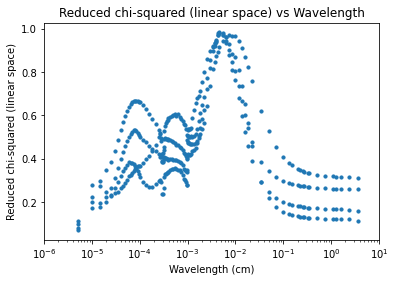

In [156]:
# Reduced chi-squared vs wavelength (linear space)
plt.scatter(corr['Wavelength (cm)'], corr['Reduced chi-squared (linear space)'], s=10)
plt.title('Reduced chi-squared (linear space) vs Wavelength')
plt.xlabel('Wavelength (cm)')
plt.ylabel('Reduced chi-squared (linear space)')
plt.xscale('log')
plt.xlim(1e-6, 1e1)
plt.savefig(f'Figures/linear_rcs_vs_wavelength.jpg')
plt.show()

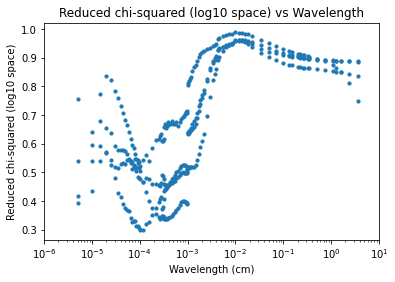

In [158]:
# Reduced chi-squared vs wavelength (log10 space)
plt.scatter(corr['Wavelength (cm)'], corr['Reduced chi-squared (log10 space)'], s=10)
plt.title('Reduced chi-squared (log10 space) vs Wavelength')
plt.xlabel('Wavelength (cm)')
plt.ylabel('Reduced chi-squared (log10 space)')
plt.xscale('log')
plt.xlim(1e-6, 1e1)
plt.savefig(f'Figures/log10_rcs_vs_wavelength.jpg')
plt.show()

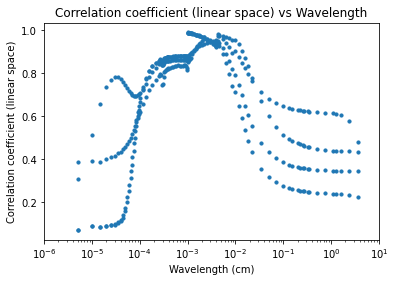

In [160]:
# Correlation coefficient vs wavelength (linear space)
plt.scatter(corr['Wavelength (cm)'], corr['Correlation coefficient (linear space)'], s=10)
plt.title('Correlation coefficient (linear space) vs Wavelength')
plt.xlabel('Wavelength (cm)')
plt.ylabel('Correlation coefficient (linear space)')
plt.xscale('log')
plt.xlim(1e-6, 1e1)
plt.savefig(f'Figures/linear_cc_vs_wavelength.jpg')
plt.show()

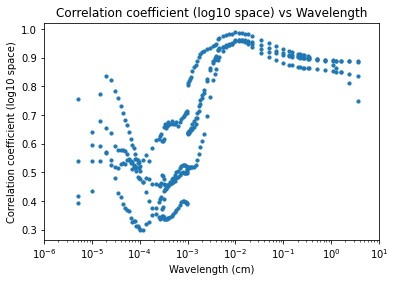

In [162]:
# Correlation coefficient vs wavelength (log10 space)
plt.scatter(corr['Wavelength (cm)'], corr['Correlation coefficient (log10 space)'], s=10)
plt.title('Correlation coefficient (log10 space) vs Wavelength')
plt.xlabel('Wavelength (cm)')
plt.ylabel('Correlation coefficient (log10 space)')
plt.xscale('log')
plt.xlim(1e-6, 1e1)
plt.savefig(f'Figures/log10_cc_vs_wavelength.jpg')
plt.show()

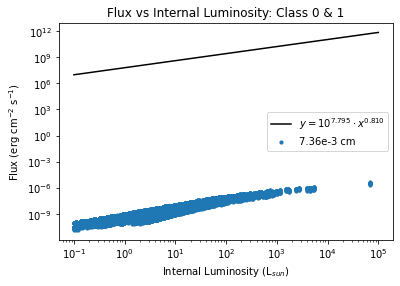

In [168]:
features = df[df['Wavelength (cm)'] == 0.0073570602450168]
# Class 2 (0 & 1)
plt.scatter(features['L_int (Lsun)'], features['Flux (erg cm^-2 s^-1)'], s=10)
plt.title('Flux vs Internal Luminosity: Class 0 & 1')
plt.xlabel('Internal Luminosity (L$_{sun}$)')
plt.ylabel('Flux (erg cm$^{-2}$ s$^{-1}$)')
plt.xscale('log')
plt.yscale('log')

# Fit linear regression
flux = sm.add_constant(features['log(Flux)'])
model = sm.OLS(features['log(L_int)'], flux)
results = model.fit()
m, unc_m, b, unc_b = results.params[1], results.bse[1], results.params[0], results.bse[0]

# Visualize linear regression
L = np.linspace(1e-1, 1e5)
F = L**m * 10**b
plt.plot(L, F, color='k')
plt.legend([f'$y = 10^{{{b:.3f}}} \cdot x^{{{m:.3f}}}$', f'{Decimal(0.0073570602450168):.2e} cm'])
plt.show()